# Training a simple MLP Classifier

In [2]:
# Import package and load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from IPython.display import Markdown

import pickle
from time import time, localtime, asctime

Before investing a lot of time in training a more complicated Neural Network, we'll start with a simple [Scikit Learn MLP Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.predict_proba). We'll begin by loading one of the CSVs generated from the MNIST Special Database 19 original images and matched to provide writer, character and character class labels.

In [3]:
start = 20
end = 40

data_dir = "data/intermediate/"
chunking = "chunking/"
hashes = "hashes/"
csvs = "csvs/"

base_mnist_path = "../mnist/"
by_field_dir = "by_field/"

Some of these columns data types are not inferred well by pandas, so we'll load them all as strings, and then explicitly set the types.

In [5]:
df = pd.read_csv(data_dir+csvs+"mnist_chunks_"+str(start)+"_to_"+str(end)+"_pixel.csv", dtype="str")

In [6]:
df = df.astype({"pixel_"+str(pixel_1d):np.uint8 for pixel_1d in range((128**2))})

#df.dtypes

In [177]:
df = df.astype({"label": "category", "char_type": "category", "author_id": "category"})
#df.dtypes

summary = df.groupby("author_id")["author_id"]

number_authors= len(df["author_id"].unique())
doc = "There are {} authors in the loaded dataset with {} samples\
            and a min/max of {}/{} samples per author.".format(number_authors, df.shape[0], summary.count().min(), summary.count().max())
display(Markdown(doc))

There are 10 authors in the loaded dataset with 3812 samples            and a min/max of 315/418 samples per author.

Next, the dataset will be split into training (75%) and test (25%) sets so we can evaluate perfomance rather than overfitting to the data.

In [183]:
# Split data into testing and training data
train_features, test_features, train_outcome, test_outcome = train_test_split(
    df.drop(["author_id", "label", "char_type"], axis=1),
    df["author_id"], random_state=0
)

In [56]:
display(Markdown("Train and Test sets both contain all writers: {}".format(len(list(set(train_outcome) - set(test_outcome)))==0)))

Train and Test sets both contain all writers: True

Now we'll train the classifier with a 3 hidden layer perceptron net (256, 256, 128), using the default "adam" solver, and a max iteration of 20 for times sake.

In [98]:
# Create and fit the classifier (use a pipeline to incorporate this into the full process!)

#param_grid = {"mlpclassifier__"}

#grid_search = GridSearchCV(MLPClassifier(), param_grid, verbose=0, cv=folds, return_train_score=True)

#grid_search.fit(train_features, train_outcome)
#with the full dataset, solver="adam" is preferred, with this small sample, "sgd" should be faster
mlp = MLPClassifier((256, 256, 128, ), solver="adam", verbose=True, max_iter=20, random_state=0).fit(train_features, train_outcome)

Iteration 1, loss = 2.05995694
Iteration 2, loss = 1.69342057
Iteration 3, loss = 1.44628413
Iteration 4, loss = 1.20708196
Iteration 5, loss = 1.00180772
Iteration 6, loss = 0.80007769
Iteration 7, loss = 0.61678133
Iteration 8, loss = 0.47995336
Iteration 9, loss = 0.37626276
Iteration 10, loss = 0.26643358
Iteration 11, loss = 0.19128335
Iteration 12, loss = 0.16582388
Iteration 13, loss = 0.12686051
Iteration 14, loss = 0.09179687
Iteration 15, loss = 0.06475829
Iteration 16, loss = 0.04236278
Iteration 17, loss = 0.03304042
Iteration 18, loss = 0.02748750
Iteration 19, loss = 0.01943220
Iteration 20, loss = 0.01671363


c:\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [99]:
# Assess predictions
score = mlp.score(test_features, test_outcome)

display(Markdown("This models accuracy is {:.2f}".format(score)))

This models accuracy is 0.49

This doesn't seem very good. Let's take a closer look at the data and predictions to try and identify the challange (besides a low number of iterations).

In [184]:
bins = [i for i in range(0,number_authors+1)]

In [185]:
probability = mlp.predict_proba(test_features.iloc[0,].values.reshape(1, -1))
probability

array([[1.29825111e-08, 3.90755990e-13, 7.00236788e-04, 2.26823073e-09,
        9.99181164e-01, 1.12076299e-04, 6.49831457e-15, 7.12180793e-10,
        6.50695204e-06, 9.44257492e-13]])

In [186]:
display(Markdown("A single sample from author {} for the character {}".format(test_outcome.iloc[0], df.iloc[0, ]["label"])))

display()

output = "<table><th>Author</th><th>Probability<th>"
for i, target_class in enumerate(mlp.classes_):
    output += "<tr><td>{}</td><td>{:.8f}</td></tr>".format(target_class, probability[0][i])
        
output += "</table>"        

display(Markdown(output))
    

A single sample from author 0004 for the character W

<table><th>Author</th><th>Probability<th><tr><td>0000</td><td>0.00000001</td></tr><tr><td>0001</td><td>0.00000000</td></tr><tr><td>0002</td><td>0.00070024</td></tr><tr><td>0003</td><td>0.00000000</td></tr><tr><td>0004</td><td>0.99918116</td></tr><tr><td>0005</td><td>0.00011208</td></tr><tr><td>0006</td><td>0.00000000</td></tr><tr><td>0007</td><td>0.00000000</td></tr><tr><td>0008</td><td>0.00000651</td></tr><tr><td>0009</td><td>0.00000000</td></tr></table>

The classifier gives it a very high probability of being author 4 based only on the training set used to learn it. Maybe some are distinctive enough while others are more challenging, let's look at that.

In [187]:
test_features["preds"] = mlp.predict(test_features)

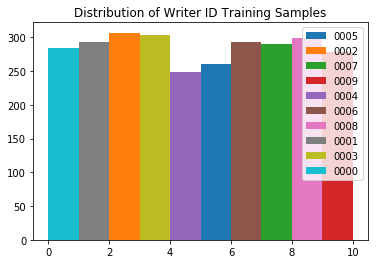

In [188]:
train_features["author_id"] = train_outcome
for author_id in train_outcome.unique():
    author_id_train = train_features[train_features["author_id"] == author_id]["author_id"].astype(np.int8)
    plt.hist(author_id_train, label=author_id, bins=bins)

plt.title("Distribution of Writer ID Training Samples")
plt.legend()
    
plt.show()

There appears to be a fairly uniform distribution of training samples, and quite a few of them given the min/max we noted earlier.

In [220]:
test_features["author_id"] = test_outcome

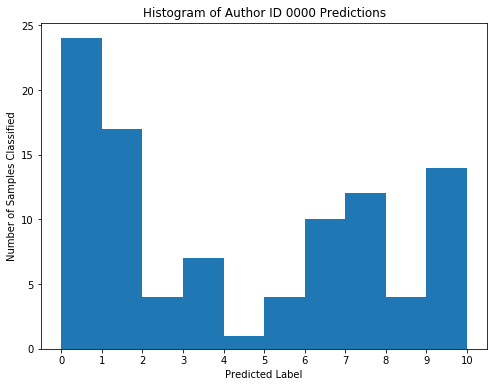

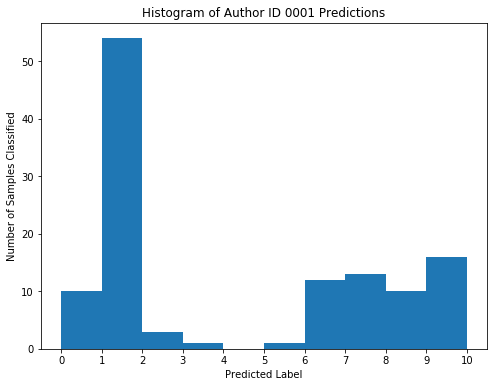

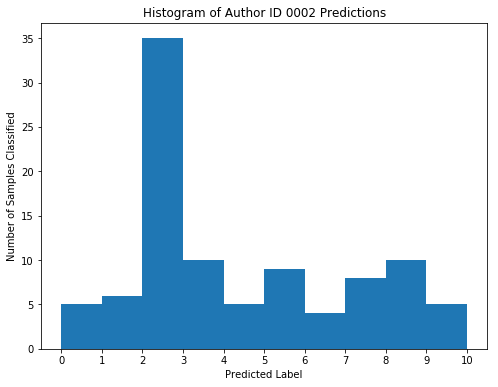

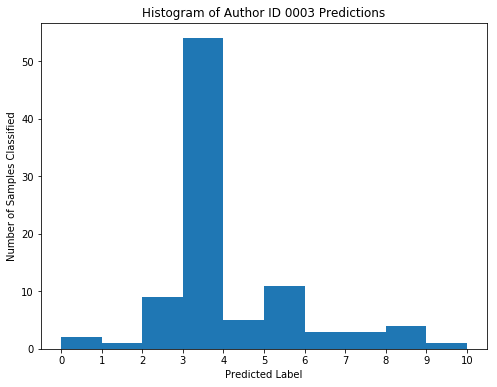

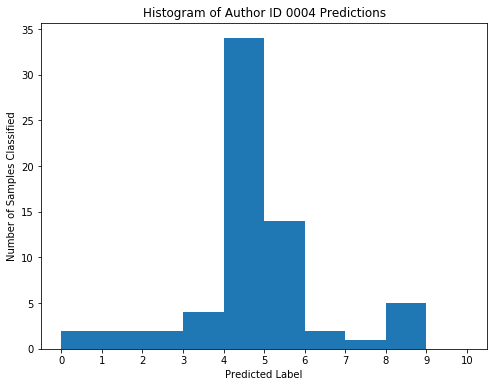

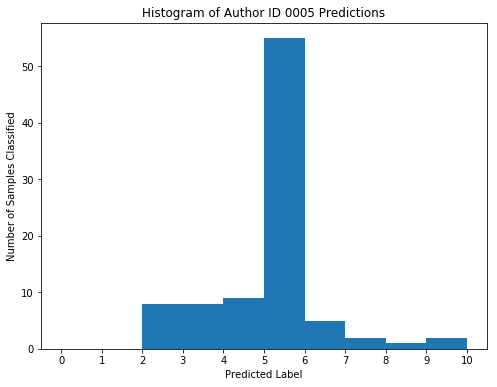

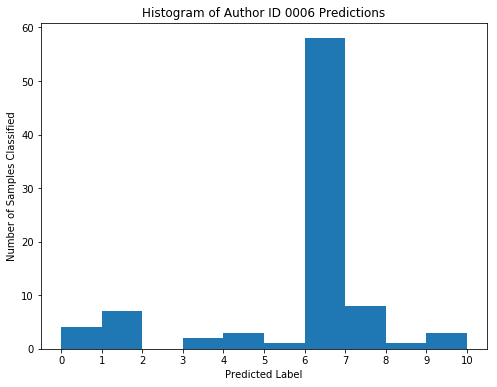

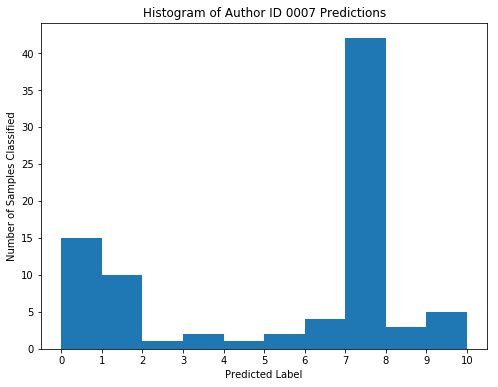

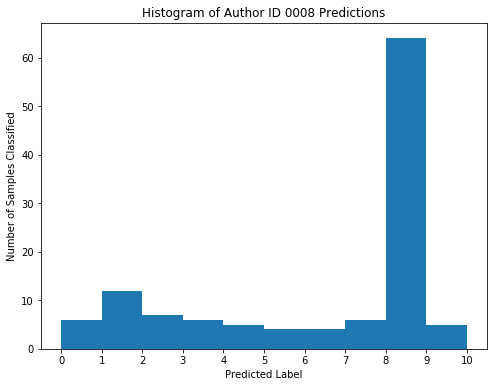

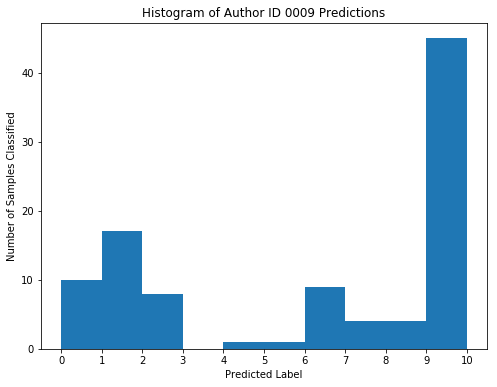

In [276]:

for author_id in test_outcome.sort_values().unique():
    author_id_df = test_features[test_features["author_id"]==author_id]["preds"].astype(np.int8)

    plt.figure(figsize=(8,6))
    plt.hist(author_id_df, bins=bins)
    plt.title("Histogram of Author ID {} Predictions".format(author_id))
    plt.xlabel("Predicted Label")
    plt.ylabel("Number of Samples Classified")
    plt.xticks(ticks=bins, labels=bins)
    plt.show()

For many of the writers, it appears the confidence seems relatively high on many predictions, given the low accuracy we observed initially.

Another way we might get a more concise overview of these results is utilizing a scatter plot as a simple 2D histogram. The alpha is set to 0.01, meaning 100 correct predictions would give an opaque point.

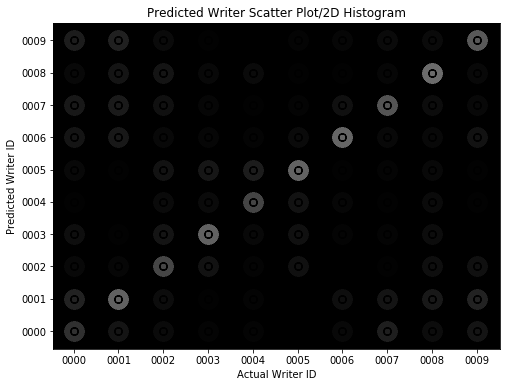

In [278]:
sorted_by_author = test_features.sort_values(by=["author_id"], axis=0)
#using sorted by pred doesnt represent the same distributions we see in the hist, something's going wrong there,
#have been trying to order them so it's easier to see which ones are "mostly right" along the diagonal
#sorted_by_pred = test_features.sort_values(by=["preds"], axis=0)

plt.figure(figsize=(8, 6))

for author_id in sorted_by_author["author_id"].unique():
    #display(just_this_auth.groupby("preds")["preds"].count())

    just_this_auth = sorted_by_author[sorted_by_author["author_id"]==author_id]
    plt.scatter(just_this_auth["author_id"],\
                just_this_auth["preds"].sort_values(), alpha=0.01, linewidths=15, c="white")

plt.title("Predicted Writer Scatter Plot/2D Histogram")
plt.xlabel("Actual Writer ID")
plt.ylabel("Predicted Writer ID")
plt.gca().set_facecolor("black")
plt.show()

In [192]:
tm = asctime(localtime(time())).replace(" ", "_").replace(":", ".")

mdl_pickle = open("mlp_author_id_"+tm+".pickle", "wb")
pickle.dump(mlp, mdl_pickle)
mdl_pickle.close()

In [9]:
# mdl_pickle = open("mlp_author_id_Fri_Mar__8_11.45.41_2019.pickle", "rb")
# mlp = pickle.load(mdl_pickle)
# mdl_pickle.close()

Finally, let's take a look at the filters generated themselves. While we may not be able to make any really specific statements, it might give us some larger general idea about what was found statistically to improve the classification.

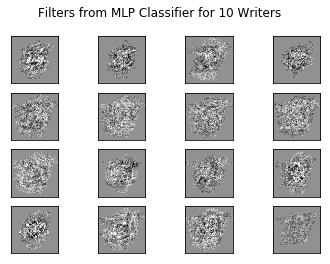

In [198]:
fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(128, 128), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

fig.suptitle("Filters from MLP Classifier for 10 Writers")

plt.show()